
## <font color=Green>Forecasting air transport passengers </font>

<br>


We have time series data at hand showing passengers carried in a set of countries over the world.
A data product which could be developed, for the airline industry (or a specific airline) could be a prediction of the development in the trend for the next few years*.
For a global airline, or an industry association, this data could inform corporate strategy decisions: market-level growth rates could be compared across countries, to help assess which could be more attractive and steer resource allocation where it matters the most.

For simplicity, we can the Facebook Prophet** model, a well-known time series forecasting algorithm developed by Facebook, and pick a couple countries to provide a proof of concept.

Note 1: Our data does not include COVID, which affected the industry quite a bit, so this is a clear limitation 

Note 2: https://facebook.github.io/prophet/

Some info about Prophet:

- Prophet is open source software released by Facebook’s Core Data Science team.

- Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 

- Prophet works best with time series that have strong seasonal effects and several seasons of historical data. 

<br><br>
### <font color=White> 1. Install Prophet and perform imports:</font>


In [1]:
pip install fbprophet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from fbprophet import Prophet



In [3]:
#make our figures more readable
pd.options.display.float_format = '{:,.2f}'.format

<br><br>
### <font color=White>2. Import the dataset </font>

In [4]:
  from google.colab import files
  uploaded = files.upload()

Saving API_IS.AIR.PSGR_DS2_en_csv_v2_3358196.csv to API_IS.AIR.PSGR_DS2_en_csv_v2_3358196.csv


In [5]:
# Once your file is on the Virtual Machine, you can check if the file is there.
!ls

API_IS.AIR.PSGR_DS2_en_csv_v2_3358196.csv  sample_data


<br><br>
### <font color=White>**3. Declare the dataset as a data frame and visualise it**</font>

In [6]:
import io
ts_data = pd.read_csv(io.BytesIO(uploaded['API_IS.AIR.PSGR_DS2_en_csv_v2_3358196.csv']), skiprows=4)
ts_data.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,"Air transport, passengers carried",IS.AIR.PSGR,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"223,502.00","274,280.00",nan,nan,nan
1,Africa Eastern and Southern,AFE,"Air transport, passengers carried",IS.AIR.PSGR,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"3,418,300.00","3,775,300.00","4,074,500.00","4,808,000.00","5,126,100.00","5,333,100.00","6,040,400.00","5,798,900.00","6,195,600.00","7,515,200.00","8,614,600.00","9,063,100.00","9,088,900.00","8,973,900.00","9,474,400.00","9,385,300.00","8,825,600.00","9,837,400.00","10,931,600.00","11,110,800.00","11,257,400.00","10,802,900.00","10,302,700.00","11,082,400.00","11,775,500.00","12,153,400.00","13,178,400.00","13,456,500.00","13,234,700.00","14,038,500.00","14,963,609.00","14,546,112.00","14,462,573.00","15,802,323.00","17,562,611.00","20,661,751.00","22,039,609.00","23,295,972.00","23,988,552.00","23,800,085.00","30,374,164.94","33,507,824.27","35,838,679.01","35,112,457.82","36,350,758.95","39,154,692.00","41,553,429.00","45,423,814.08","52,613,964.08","54,335,254.28",nan,nan
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"84,700.00","97,400.00","104,900.00","96,600.00","96,100.00","99,000.00","101,700.00","111,200.00","100,400.00","93,000.00","76,200.00","129,100.00","181,000.00","200,200.00","220,400.00","225,500.00","184,400.00","217,900.00","201,000.00","220,000.00","241,400.00","212,300.00","212,300.00","197,000.00","238,400.00","250,400.00","255,600.00","89,600.00","52,700.00","140,200.00","149,705.00",nan,nan,nan,nan,nan,nan,nan,nan,nan,"1,999,127.00","2,279,341.18","1,737,962.13","2,044,188.00","2,209,428.00","1,929,907.00","1,917,924.00","1,647,425.00","1,125,367.00","1,066,747.36",nan,nan
3,Africa Western and Central,AFW,"Air transport, passengers carried",IS.AIR.PSGR,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"1,167,000.00","1,238,100.00","1,285,700.00","1,453,300.00","1,685,700.00","1,987,500.00","2,540,000.00","2,962,100.00","3,543,900.00","3,776,100.00","4,404,900.00","5,147,600.00","5,190,100.00","5,423,600.00","5,311,800.00","5,794,300.00","5,265,300.00","4,485,000.00","3,930,700.00","3,602,400.00","3,551,000.00","3,405,900.00","3,209,800.00","2,840,600.00","3,167,100.00","3,215,200.00","2,855,900.00","3,020,900.00","3,007,600.00","3,083,500.00","2,949,248.00","2,627,404.00","2,072,438.00","2,081,206.00","2,604,956.00",nan,nan,nan,nan,nan,"7,817,344.20","9,140,452.13","9,570,161.79","8,677,884.00","8,030,237.17","8,696,300.00","8,129,874.00","8,837,017.00","12,337,766.28","11,346,590.74",nan,nan
4,Angola,AGO,"Air transport, passengers carried",IS.AIR.PSGR,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"155,400.00","282,700.00","308,000.00","546,100.00","635,200.00","801,100.00","890,500.00","952,500.00","689,600.00","894,200.00","727,000.00","746,000.00","750,000.00","509,800.00","451,500.00","456,000.00","440,000.00","333,500.00","519,000.00","552,500.00","585,000.00","555,000.00","552,900.00","293,800.00","235,448.00","193,317.00","189,619.00","198,253.00","222,032.00","239,795.00","262,666.00","277,361.00","283,887.00","274,869.00","1,010,194.00","987,798.00","1,132,424.00","1,321,872.00","1,409,952.00","1,244,491.00","1,482,546.00","1,375,523.00","1,516,628.00","1,436,959.00",nan,nan


In [7]:
ts_data.shape

(266, 66)

In [8]:
ts_data['Indicator Name'].value_counts()

Air transport, passengers carried    266
Name: Indicator Name, dtype: int64

In [9]:
#drop non-necessary columns, and columns where data is always incomplete
drop_cols = ['Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '2020', 'Unnamed: 65']

In [10]:
#create "prep" df, to be used for analysis
ts_data_prep = ts_data.drop(columns=drop_cols).copy()

#drop missing values (this is a very simplistic solution, other solutions such as inputing could have been used)
ts_data_prep.dropna(inplace=True)

#by running the shape method, we can see we are left with 106 rows & 51 columns, while we started with 266 and 66
ts_data_prep.shape

(106, 51)

In [11]:
#let's melt the dataframe so that the df is prepped for Prophet
ts_data_prep = ts_data_prep.melt(id_vars='Country Name').rename(columns={'variable':'Year'})

In [12]:
#let's pick 2 countries: BE and USA
ts_data_prep_be = ts_data_prep.loc[ts_data_prep['Country Name'] == 'Belgium']
ts_data_prep_us = ts_data_prep.loc[ts_data_prep['Country Name'] == 'United States']

<br><br>
### <font color=White>**4. Take a look at the descriptive stats**</font>

* What is the min/average/max numbe of passengers per year?


In [32]:
ts_data_prep_be.describe()

,value
count,50.00
mean,"5,050,390.41"
std,"3,880,018.79"
min,"1,366,200.00"
25%,"2,034,425.00"
50%,"3,205,441.00"
75%,"8,248,901.83"
max,"14,279,187.00"


Text(0, 0.5, 'Frequency')

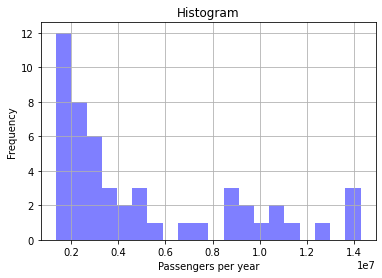

In [14]:
#BE
# Create a histogram to observe the distribution of passengers per year
ts_data_prep_be['value'].hist(color='blue', alpha=0.5, bins=20)

# Add labels
plt.title('Histogram')
plt.xlabel('Passengers per year')
plt.ylabel('Frequency')

#data looks quite spread out

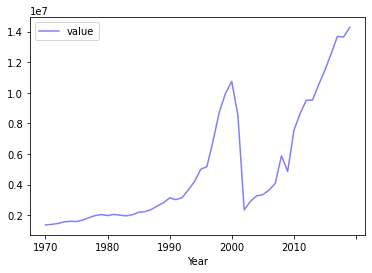

In [15]:
# Create a line chart to observe the evolution of passengers (per year)

ts_data_prep_be.set_index('Year').plot(color='blue', alpha=0.5)

#the graph shows a clear drop in 2001, we can deduce it most likely has something to do with 9/11

Text(0, 0.5, 'Frequency')

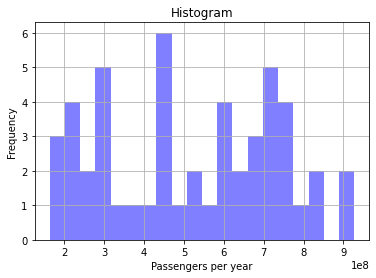

In [16]:
#US
# Create a histogram to observe the distribution of passengers per year
ts_data_prep_us['value'].hist(color='blue', alpha=0.5, bins=20)

# Add labels
plt.title('Histogram')
plt.xlabel('Passengers per year')
plt.ylabel('Frequency')

#data looks quite spread out

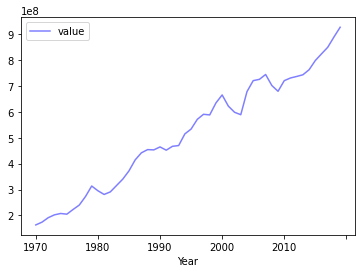

In [17]:
# Create a line chart to observe the evolution of passengers (per year)

ts_data_prep_us.set_index('Year').plot(color='blue', alpha=0.5)

#surprisingly, the drop in 2000 is much less pronounced in the US than in Belgium.
#this is the point where having a chat with a domain expert is important
#since we don't have that option, let's pick another country to see the pattern there

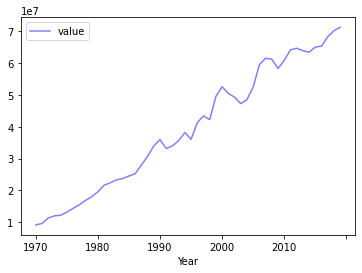

In [18]:
#france looks like the US [not showing it, but DE and IT also look closer to the US than to BE]
#belgium could be an outlier, so to be safe let's replace it with France
ts_data_prep_fr = ts_data_prep.loc[ts_data_prep['Country Name'] == 'France']
ts_data_prep_fr.set_index('Year').plot(color='blue', alpha=0.5)

<br><br>
### <font color=White>5. Declare the variable to predict (*y*) and the date (*ds*) </font>

In [19]:
#let's prepare the data for Prophet
ts_pred_fr = ts_data_prep_fr.iloc[:,1:]
ts_pred_fr.columns = ["ds", "y"]
ts_pred_fr.head(5)

,ds,y
31,1970,"9,108,000.00"
137,1971,"9,569,200.00"
243,1972,"11,285,100.00"
349,1973,"11,957,500.00"
455,1974,"12,159,300.00"


<br><br>
### <font color=White>6. Making a prediction </font>

* Create the first model ($m_1$) and fit the data to our dataframe:

In [20]:
#one important parameter for the model is growth, which function to use
#default is linear, which assumes a linear growth (see below cell)
#realistically, this is a very optimistic function, as economies get richer, and
#air travel gets more accessible, but there is such a thing as diminishing returns
#(if we look at the linear plots for DE and IT we can see them already)
#it's what FB call a "saturating forecast"
#this we can manage with some hyperparameter tuning (growth)
#and by picking cap & floor values

ts_pred_fr['cap'] = ts_data_prep_fr['value'].max()*1.1
ts_pred_fr['floor'] = ts_data_prep_fr['value'].min()*0.9


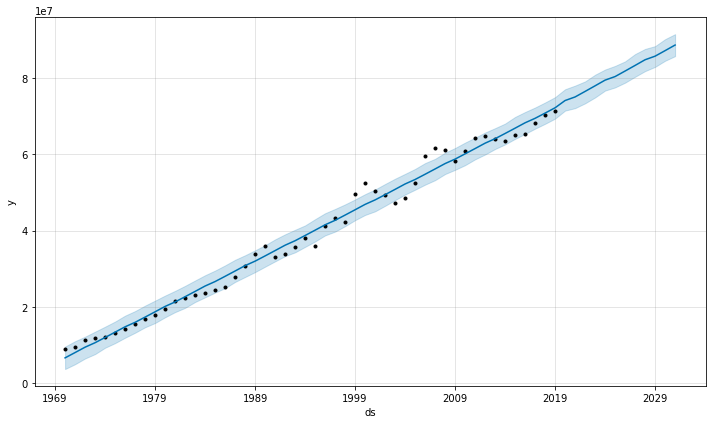

In [21]:
m2= Prophet(daily_seasonality=False, weekly_seasonality=False)
m2.fit(ts_pred_fr[['ds', 'y']])
future = m2.make_future_dataframe(periods=12, freq='Y')
forecast = m2.predict(future)
m2.plot(forecast);

In [22]:
m1= Prophet(growth='logistic', changepoint_prior_scale=1, daily_seasonality=False, weekly_seasonality=False)
m1.fit(ts_pred_fr)

<br><br>
* To tell **Prophet** how far to predict in the future, use  ```make_future_dataframe```. 

In [23]:
# let's pick the prediction period, e.g. 12 years
future = m1.make_future_dataframe(periods=12, freq='Y')
future['cap'] = ts_data_prep_fr['value'].max()*1.1
future['floor'] = ts_data_prep_fr['value'].min()*0.9

# then make the forecast
forecast = m1.predict(future)

In [24]:
# To see the last 5 predicted values:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','floor','cap']].tail()

,ds,yhat,yhat_lower,yhat_upper,floor,cap
57,2026-12-31,"71,941,523.20","69,432,996.53","74,622,684.32","8,197,200.00","78,418,204.70"
58,2027-12-31,"72,321,743.90","69,748,822.65","74,895,786.17","8,197,200.00","78,418,204.70"
59,2028-12-31,"72,025,431.83","69,552,375.67","74,916,078.13","8,197,200.00","78,418,204.70"
60,2029-12-31,"72,309,166.40","69,641,048.86","74,979,857.00","8,197,200.00","78,418,204.70"
61,2030-12-31,"72,604,310.41","69,909,653.51","75,479,364.82","8,197,200.00","78,418,204.70"


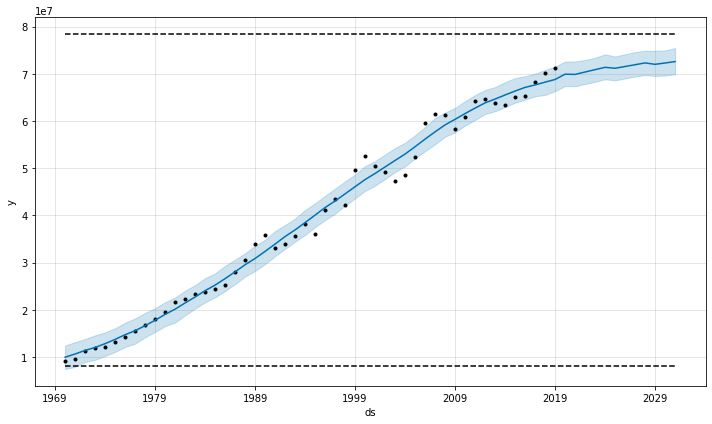

In [25]:
# Plot the data
m1.plot(forecast);

#looking at the graph, our POC model looks plausible (albeit, certainly improvable)
#most dots (datapoints) lie within the blue band, our confidence interval

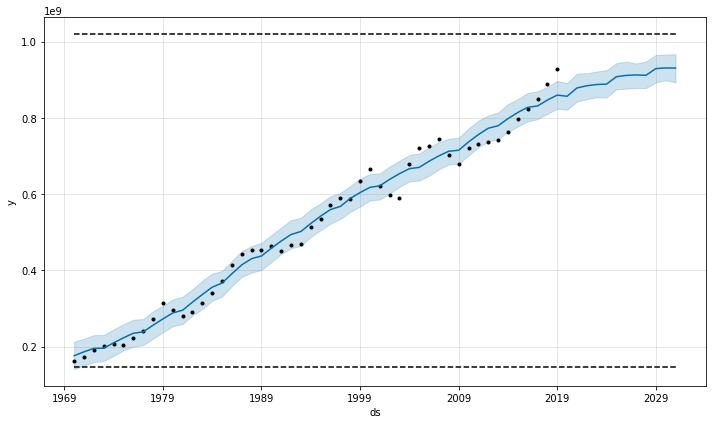

In [26]:
#let's repeat for the US

ts_pred_us = ts_data_prep_us.iloc[:,1:]
ts_pred_us.columns = ["ds", "y"]

ts_pred_us['cap'] = ts_data_prep_us['value'].max()*1.1
ts_pred_us['floor'] = ts_data_prep_us['value'].min()*0.9

m1_us= Prophet(growth='logistic', changepoint_prior_scale=1, daily_seasonality=False, weekly_seasonality=False)
m1_us.fit(ts_pred_us)

future_us = m1.make_future_dataframe(periods=12, freq='Y')
future_us['cap'] = ts_data_prep_us['value'].max()*1.1
future_us['floor'] = ts_data_prep_us['value'].min()*0.9

# then make the forecast
forecast_us = m1_us.predict(future_us)
m1_us.plot(forecast_us);

# as for france, the US model seems belivable if we look at the past, but the last
# few years before 2019 saw a surge in growth, which the model is not capturing
# this should usggest us that the model could be a bit conservative, 
# and in future iterations we should either tune the hyperparameters better or pick a different model

In [27]:
#let's generate an export file with the predictions, so we can compare
forecast = forecast.rename(columns={'yhat':'pred_fr'})
forecast_export = forecast.tail(12)[['ds', 'pred_fr']].merge(forecast_us[['ds', 'yhat']], on='ds', how='left').rename(columns={'yhat':'pred_us'})
forecast_export

,ds,pred_fr,pred_us
0,2019-12-31,"69,934,002.80","856,522,483.48"
1,2020-12-31,"69,888,901.63","878,333,813.21"
2,2021-12-31,"70,398,687.44","884,045,471.81"
3,2022-12-31,"70,897,444.20","887,378,942.39"
4,2023-12-31,"71,388,665.79","888,375,853.91"
5,2024-12-31,"71,192,486.92","907,801,239.58"
6,2025-12-31,"71,565,915.96","911,266,348.41"
7,2026-12-31,"71,941,523.20","912,486,134.69"
8,2027-12-31,"72,321,743.90","911,500,845.10"
9,2028-12-31,"72,025,431.83","929,067,951.88"


In [28]:
forecast_export

,ds,pred_fr,pred_us
0,2019-12-31,"69,934,002.80","856,522,483.48"
1,2020-12-31,"69,888,901.63","878,333,813.21"
2,2021-12-31,"70,398,687.44","884,045,471.81"
3,2022-12-31,"70,897,444.20","887,378,942.39"
4,2023-12-31,"71,388,665.79","888,375,853.91"
5,2024-12-31,"71,192,486.92","907,801,239.58"
6,2025-12-31,"71,565,915.96","911,266,348.41"
7,2026-12-31,"71,941,523.20","912,486,134.69"
8,2027-12-31,"72,321,743.90","911,500,845.10"
9,2028-12-31,"72,025,431.83","929,067,951.88"


Looking at the curve, and at the predicted values, France is supposed to grow slightly faster than the US, meaning our "resource allocation informer tool" suggests we should prioritize it (in this simplified example, ignoring anything except growth rates in carried passengers).
Let's take a quick look at some cross-validation metrics to assess whether our little tool is working.

<br><br>
### <font color=White>7. Diagnostics </font>

* Prophet includes functionality for time series cross validation to measure forecast error using historical data. 
* This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. 
* We can then compare the forecasted values to the actual values. 
<br>

In [29]:
# Cross-validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m1, horizon = '12 y')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2007-01-01 02:09:36 and 2007-01-01 02:09:36


  0%|          | 0/1 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2008-01-01,"57,777,068.37","54,969,066.36","60,563,912.97","61,214,656.00",2007-01-01 02:09:36
1,2009-01-01,"59,074,222.40","56,253,769.73","61,651,446.86","58,318,312.00",2007-01-01 02:09:36
2,2010-01-01,"59,817,537.65","57,263,577.59","62,610,957.18","60,864,422.11",2007-01-01 02:09:36
3,2011-01-01,"60,565,074.35","57,797,760.42","63,283,601.12","64,185,339.34",2007-01-01 02:09:36
4,2012-01-01,"61,319,162.40","58,415,615.11","63,978,999.19","64,683,769.02",2007-01-01 02:09:36


In [30]:
# Performance metrics
# if we look at errors in absolute terms, they are in the ballpark of millions
# however, if we look in percentage terms, we should be fairly satisfied with our
# little PoC, looking at this quick backtesting
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()
df_p.mean(axis=0)

horizon      2374 days 03:50:24
mse        9,696,854,890,589.70
rmse               2,638,883.74
mae                2,638,883.74
mape                       0.04
mdape                      0.04
coverage                   0.50
dtype: object

<br><br>
### <font color=White>**7. Saving the predictions**</font>

In [31]:
#To download the file with the forecasts as a .csv
forecast_export.to_csv('forecast_export.csv')
files.download('forecast_export.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>